In [1]:
# How much do embedding algorithms agree with each other 
# distribution of distances 

In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgb, to_rgba
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import SpectralEmbedding
import utils
import scipy.sparse.linalg as lg
import networkx as nx
import networkx.algorithms.cluster as cluster
%matplotlib inline

In [2]:
def sdne_lambda(core, d):
    return
def hope_lambda(core, d):
    return
def lap_lambda(core, d):
    return
def n2v_lambda(core, d):
    return
def pca_lambda(core, d):
    return

In [10]:
graphNames = ["wiki", "facebook", "ppi", "lastfm", "physics", "AS", "ER-2", "ER-4", "BA-5", "BA-10", "enron", "BTER-from-BA", "BTER-arbitrary"]
#graphNames = ["facebook"]
for graphName in graphNames:
    try:
        with open("embeddings_all_cores/{}_embeddings.pickle".format(graphName), "rb") as pickleFile:
            embeddings = pickle.load(pickleFile)
    except:
        continue
    print(graphName)
    for d_s in embeddings:
        try:
            for alg in embeddings[d_s][1]:
                
                print("Dimension {}: Alg: {} Number of Cores {}".format(d_s, alg, len(embeddings[d_s][1][alg])))
        except:
            print("No Embeddings for {}".format(graphName))
    print("---------------")

wiki
Dimension 2: Alg: pca Number of Cores 49
Dimension 2: Alg: HOPE Number of Cores 49
Dimension 2: Alg: lap Number of Cores 49
Dimension 2: Alg: n2v Number of Cores 49
Dimension 2: Alg: hgcn Number of Cores 49
Dimension 2: Alg: sdne Number of Cores 49
Dimension 10: Alg: pca Number of Cores 49
Dimension 10: Alg: HOPE Number of Cores 49
Dimension 10: Alg: lap Number of Cores 49
Dimension 10: Alg: n2v Number of Cores 49
Dimension 10: Alg: hgcn Number of Cores 49
Dimension 10: Alg: sdne Number of Cores 49
Dimension 20: Alg: pca Number of Cores 49
Dimension 20: Alg: HOPE Number of Cores 49
Dimension 20: Alg: lap Number of Cores 49
Dimension 20: Alg: hgcn Number of Cores 49
Dimension 20: Alg: sdne Number of Cores 49
Dimension 128: Alg: sdne Number of Cores 49
---------------
facebook
Dimension 2: Alg: pca Number of Cores 115
Dimension 2: Alg: HOPE Number of Cores 115
Dimension 2: Alg: lap Number of Cores 115
Dimension 2: Alg: n2v Number of Cores 115
Dimension 2: Alg: hgcn Number of Cores 1

In [21]:
algs = ["pca", "HOPE", "lap", "n2v", "hgcn", "sdne"]
alg_titles = {
    "pca": "PCA",
    "HOPE": "HOPE",
    "lap": "LE",
    "n2v": "Node2Vec",
    "hgcn": "HGCN",
    "sdne": "SDNE"
}
colors = ["red", "green", "blue", "cyan", "magenta", "black"]
alphas = [0.05, 0.1, 0.2, 0.65, 0.8, 0.95]
d_s = ["128"]
num_cores = 4

In [4]:
def get_xy(embeddings_list, d):
    '''
    Get the 2D projection for the node embedddings. embeddings_list is a np.array
    '''
    assert(type(embeddings_list) == np.ndarray)
    
    if d > 2:
        #embeddings_list = TSNE(n_components=2, n_jobs=-1).fit_transform(embeddings_list)
        embeddings_list = PCA(n_components=2).fit_transform(embeddings_list)
    x = embeddings_list[:, 0]
    y = embeddings_list[:, 1]
    return x,y

def get_color(colorStr, alpha):
    r, g, b = to_rgb(colorStr)
    return (r, g, b, alpha)

def get_distances(embeddings_list):
    distances = []
    for i in range(len(embeddings_list)):
        first_node = embeddings_list[i]
        for j in range(i+1, len(embeddings_list)):
            second_node = embeddings_list[j]
            distances.append(np.linalg.norm(second_node - first_node))
    return distances

def print_core_size(embedding_by_alg, coreIdx):
    assert(coreIdx < num_cores)
    
    for alg in algs:
        if alg not in embedding_by_alg:
            continue 
        
        #assert(len(embedding_by_alg[alg]) == num_cores)
        k, core = embedding_by_alg[alg][coreIdx]
        print("Core {} is of Size {}".format(k, len(core)))
        return
    print("No embeddings found")

## Plot Embeddings

In [5]:
def plot_embedded_cores(embeddings, cores, graphName, plotting_lambda):
    '''
        Preliminary analysis of the embedded cores that simply plots the 2D projection of the embeddings.
        Generates a gridplot in which columns are embedding algorithms and rows are core numbers. 
        embeddings object with the following schema:
        embeddings = {
            "dimensionNumber":
                (
                models,
                {
                    "algorithm": [(k, np.ndarray)]
                }
                )
        }
    '''
    for d_str in d_s:
        d = int(d_str)
        models, embedding_by_alg = embeddings[d_str]
        fig, axs = plt.subplots(nrows=num_cores, ncols=len(algs), figsize=(5*len(algs), 5*num_cores))
        for r in range(num_cores):
            print_core_size(embedding_by_alg, r)

            for c in range(len(algs)):
                if algs[c] not in embedding_by_alg:
                    continue
                embedding_by_alg_core = embedding_by_alg[algs[c]]
                k, embedding_list = embedding_by_alg_core[r]
                ax = axs
                if num_cores > 1 and len(algs) == 1:
                    ax = axs[r]
                elif num_cores == 1 and len(algs) > 1:
                    ax = axs[c]
                elif num_cores > 1 and len(algs) > 1:
                    ax = axs[r][c]
                ax.set_title(algs[c] + " K = {}".format(str(k)))
                colors = [get_color("red", 0.8) if list(cores[k-1].nodes())[i] in cores[-1] 
                                                else get_color("blue", 0.5)
                          for i in range(len(cores[k - 1]))]
                try:
                    plotting_lambda(ax, embedding_list, d, colors)
                except:
                    continue
        #fig.suptitle("Graph Embeddings for {} Graph with d={}".format(graphName, d_str), fontsize=18)
        #file_title = "figs-PCA/{}-d-{}-plot-embeddings.png".format(graphName, d_str)
        #plt.savefig(file_title)

## Max Core 

In [6]:
def compare_original_degenerate_cores(embeddings, cores, graphName):
    maxCore = cores[-1]
    firstCore = cores[0]
    for d_str in embeddings:
        print(d_str)
        d = int(d_str)
        colors = []
        for i in range(len(firstCore)):
            if list(firstCore.nodes())[i] not in maxCore.nodes():
                colors.append(get_color("blue", 0.05))
            else:
                colors.append(get_color("red", 1.0))

        fig, axs = plt.subplots(nrows=len(algs), ncols=2, figsize=(10, 5*len(algs)))
        for r in range(len(algs)):
            alg = algs[r]
            print(alg)
            if alg not in embeddings[d_str][1]:
                continue
            axs[r][0].set_title("Original Maximum K-Core. Embedding Alg: {}, d={}".format(alg, d_str))
            try:
                x,y = get_xy(embeddings[d_str][1][alg][0][1], d)
                axs[r][0].scatter(x, y, c=colors)
            except:
                continue
                
            axs[r][1].set_title("Maximum K-Core. Embedding Alg: {}, d={}".format(alg, d_str))
            try:
                x,y = get_xy(embeddings[d_str][1][alg][-1][1], d)
                axs[r][1].scatter(x,y, c="red")
            except:
                continue

        file_title = "figs-PCA/{}-d-{}-max-core.png".format(graphName, d_str)
        plt.savefig(file_title)

In [31]:
def getColorsForCore(core, maxCore):
    colors = []
    for i in range(len(core)):
        if list(core.nodes())[i] not in maxCore.nodes():
            colors.append(get_color("blue", 0.5))
        else:
            colors.append(get_color("red", 0.9))
    return colors

def compare_two_cores(embeddings, cores, graphName, first_idx, second_idx):
    plt.rc('font', size=16)          # controls default text sizes
    plt.rc('axes', titlesize=20)     # fontsize of the axes title
    #plt.rc('axes', titleweight="bold")     # fontweight of the axes title
    plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

    maxCore = cores[-1]
    firstCore = cores[first_idx]
    secondCore = cores[second_idx]
    for d_str in embeddings:
        print(d_str)
        d = int(d_str)
        colors_firstCore = getColorsForCore(firstCore, maxCore)
        colors_secondCore = getColorsForCore(secondCore, maxCore)

        for r in range(len(algs)):
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
            alg = algs[r]
            print(alg)
            if alg not in embeddings[d_str][1]:
                continue
            #try:
            assert embeddings[d_str][1][alg][first_idx][0] == first_idx + 1
            x,y = get_xy(embeddings[d_str][1][alg][first_idx][1], d)
            axs[0].scatter(x, y, c=colors_firstCore)
            axs[0].set_title("K = {}\n{} d={}".format(first_idx + 1, alg_titles[alg], d_str))
            axs[0].set_xlabel("Dimension 1")
            axs[0].set_ylabel("Dimension 2")
#             except:
#                 continue
                
#             try:
            assert embeddings[d_str][1][alg][second_idx][0] == second_idx + 1
            x,y = get_xy(embeddings[d_str][1][alg][second_idx][1], d)
            axs[1].scatter(x,y, c=colors_secondCore)
            axs[1].set_title("K = {}\n{} d={}".format(second_idx+1, alg_titles[alg], d_str))
            axs[1].set_xlabel("Dimension 1")
            axs[1].set_ylabel("Dimension 2")
            
#             except:
#                 continue

In [10]:
def compare_degenerate_cores(embeddings_by_alg, cores, alg_name, d_int, axs):
    maxCore = cores[-1]
    
    start_idx = 0
    for c in range(len(embeddings_by_alg[alg_name])):
        core_idx = embeddings_by_alg[alg_name][c][0] - 1
        firstCore = cores[core_idx]
        degenerate_core_embeddings = []
        for i in range(len(firstCore)):
            if list(firstCore.nodes())[i] in maxCore.nodes():
                degenerate_core_embeddings.append(embeddings_by_alg[alg_name][c][1][i])
        degenerate_core_embeddings = np.array(degenerate_core_embeddings)
        assert(degenerate_core_embeddings.shape == embeddings_by_alg[alg_name][-1][1].shape)

        x,y = get_xy(degenerate_core_embeddings, d_int)
        axs[c].scatter(x, y, alpha=0.2)
        axs[c].set_title("k = {}".format(core_idx + 1))
#     x,y = get_xy(embeddings_by_alg[alg_name][-1][1], d_int)
#     axs[1].scatter(x,y, alpha=0.2)


## Analyze Graphs Independently

In [33]:
def analyze_embedded_cores(graphName):
    with open("embeddings_all_cores/{}_embeddings.pickle".format(graphName), "rb") as pickleFile:
            embeddings = pickle.load(pickleFile)
    with open("cores/{}_cores.pickle".format(graphName), "rb") as pickleFile:
            cores = pickle.load(pickleFile)
            
    def plot_2D_projection(axs, embedding_list, d, c=None):
        x, y = get_xy(embedding_list, d)
        axs.scatter(x,y,c=c)
        
    def plot_distances(axs, embedding_list, d):
        distances = get_distances(embedding_list)
        axs.hist(distances, density=True, histtype="step")
        
    #plot_embedded_cores(embeddings, cores, graphName, plot_2D_projection)
    #compare_original_degenerate_cores(embeddings, cores, graphName)
    #plot_embedded_cores(embeddings, cores, graphName, plot_distances)
    compare_two_cores(embeddings, cores, graphName, 69, 70)

2
pca
HOPE
lap
n2v
hgcn
sdne
10
pca
HOPE
lap
n2v
hgcn
sdne
20
pca
HOPE
lap
n2v
hgcn
sdne
128
pca
HOPE
lap


/home/liu.davi/.conda/envs/graphxai/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


n2v
hgcn
sdne


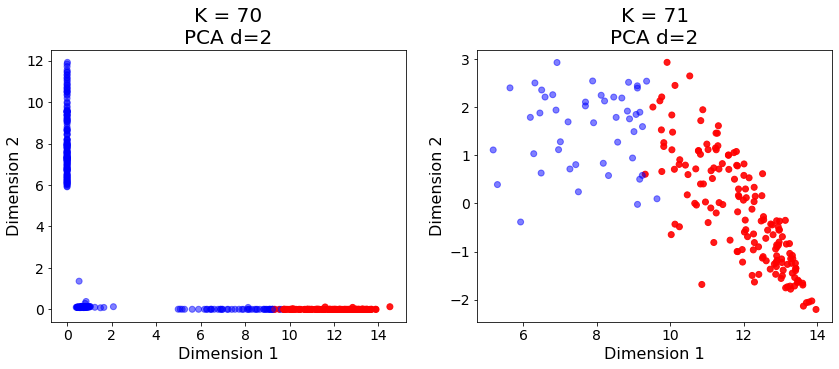

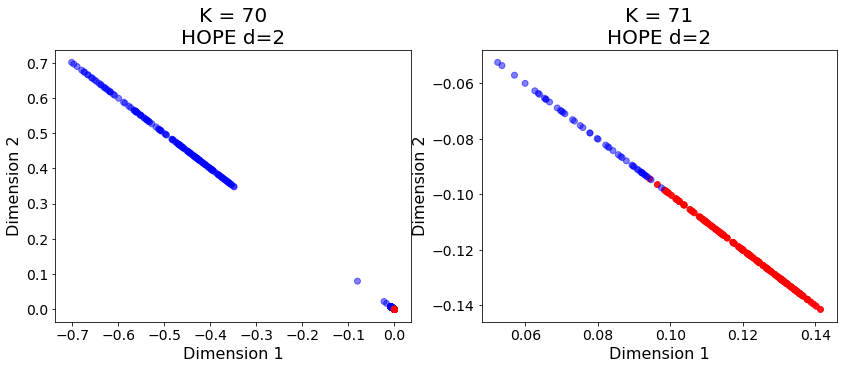

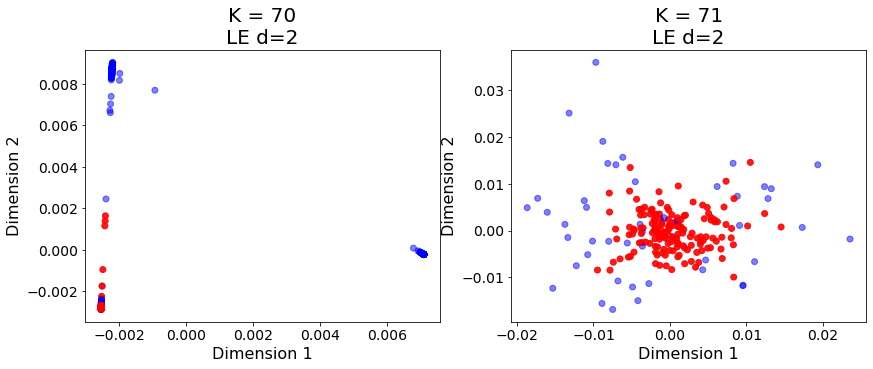

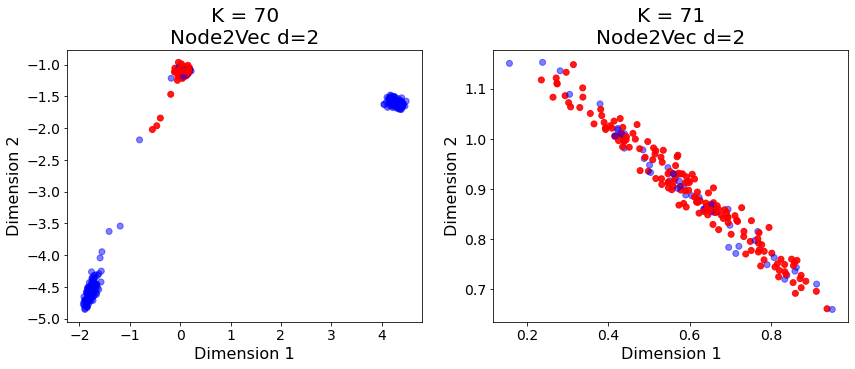

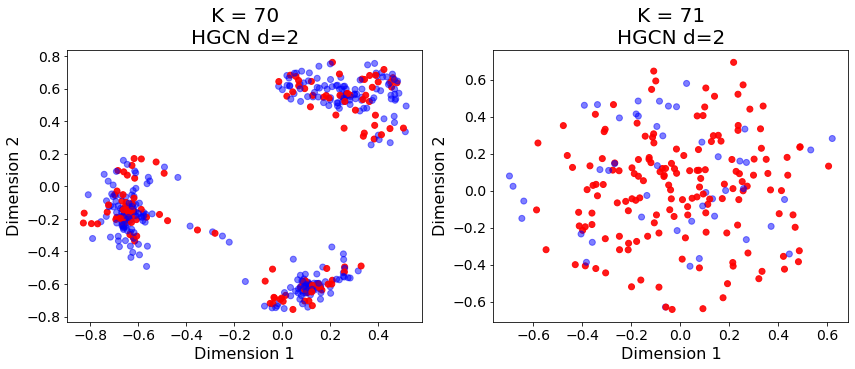

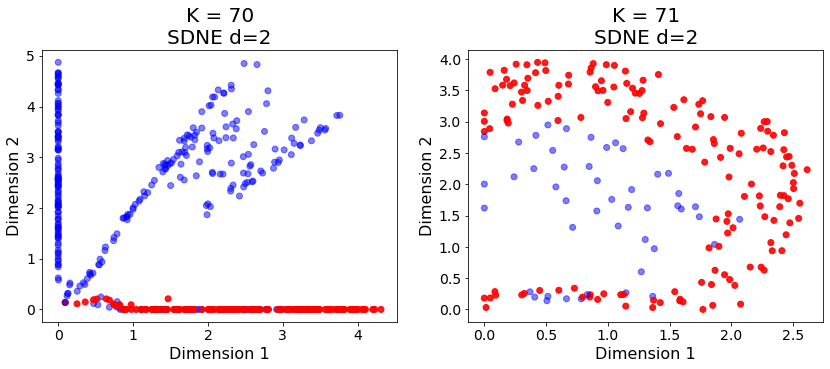

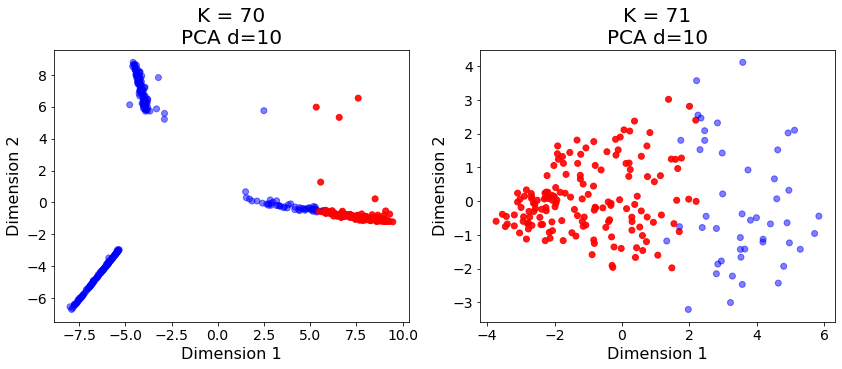

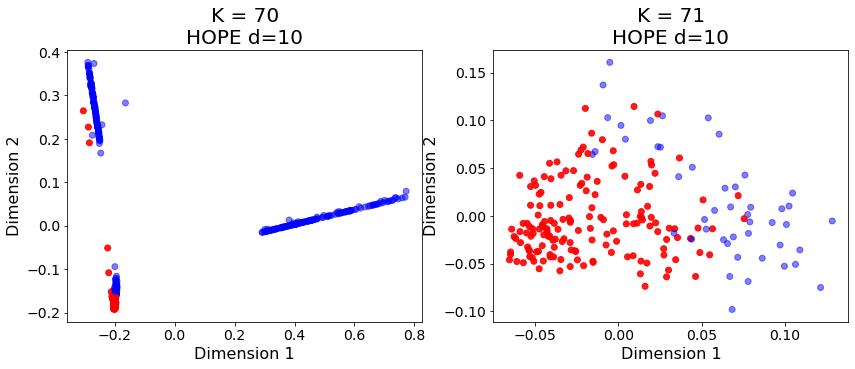

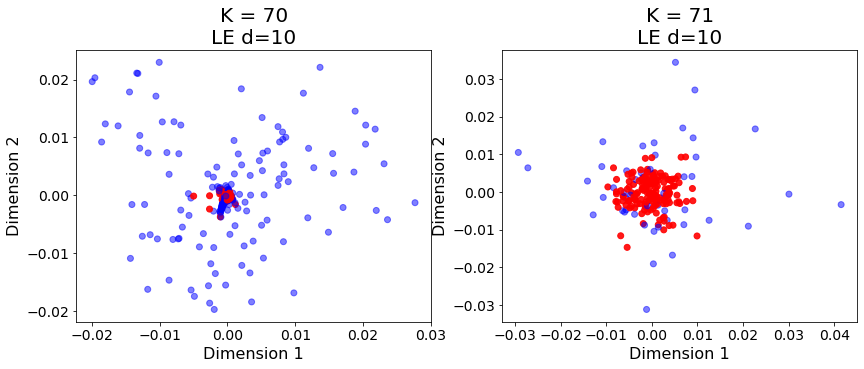

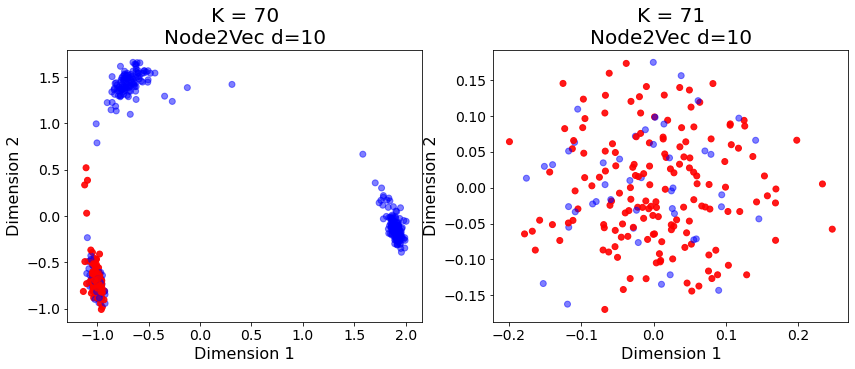

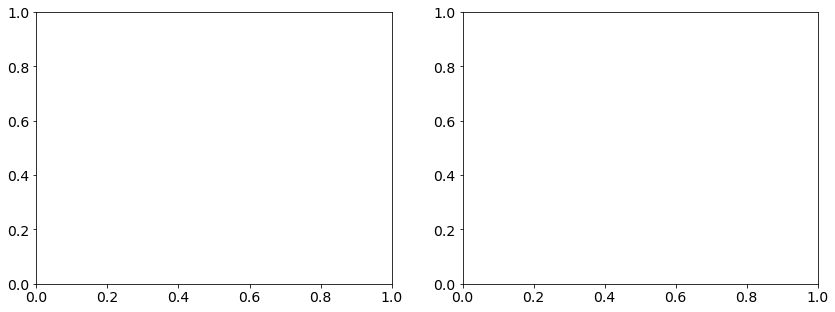

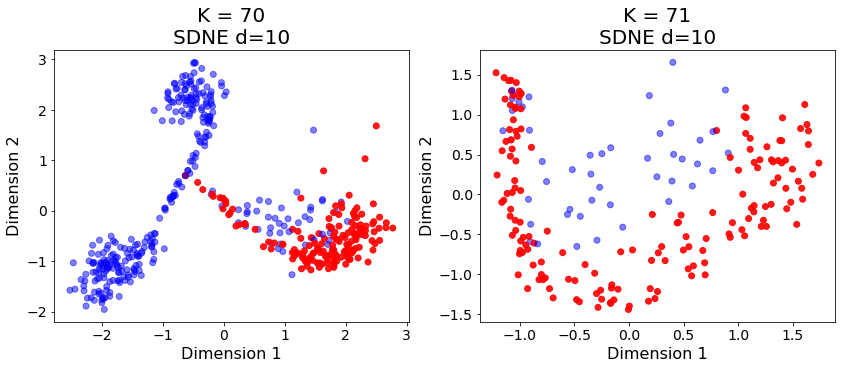

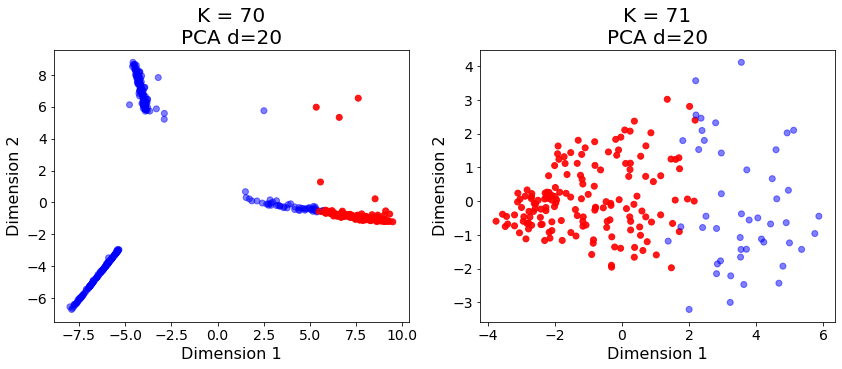

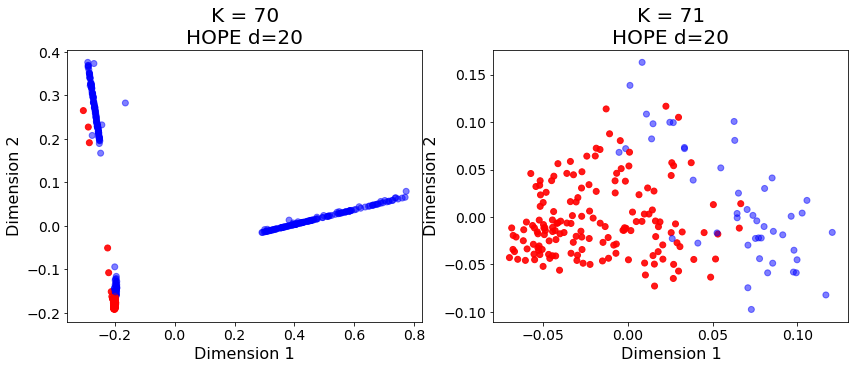

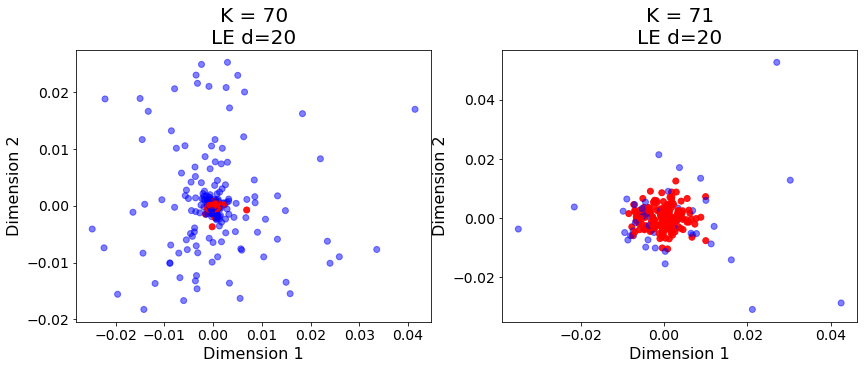

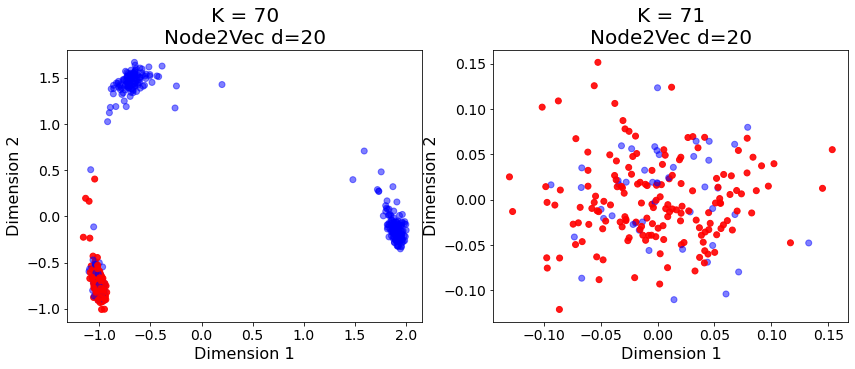

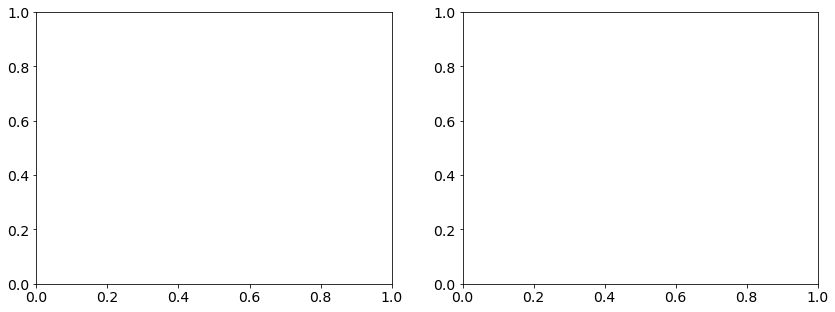

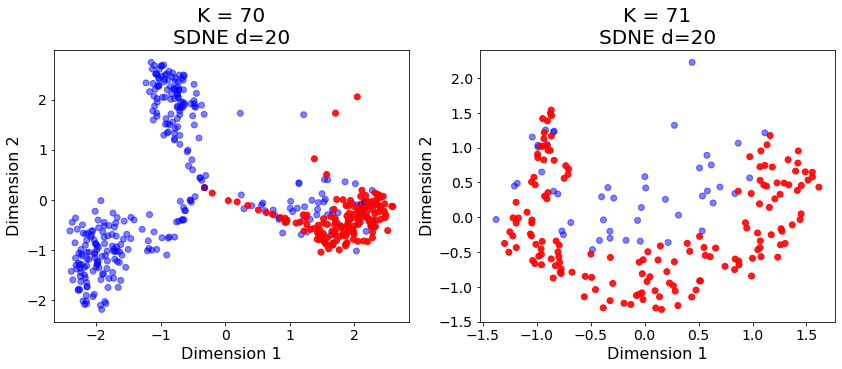

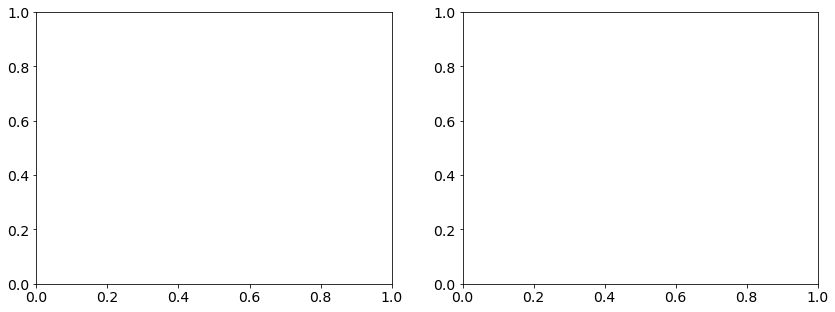

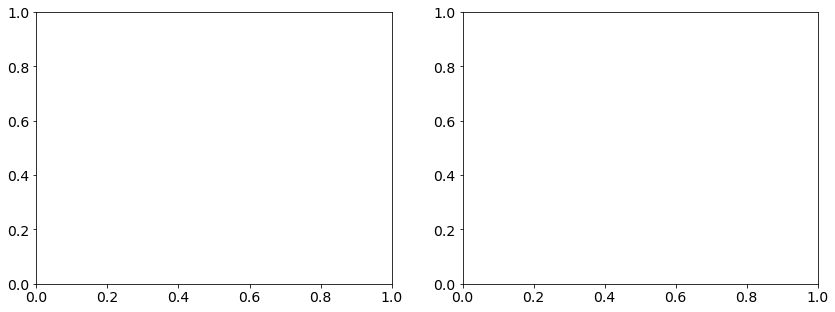

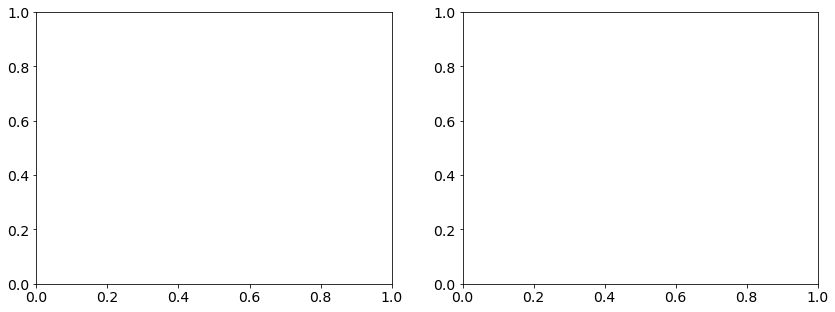

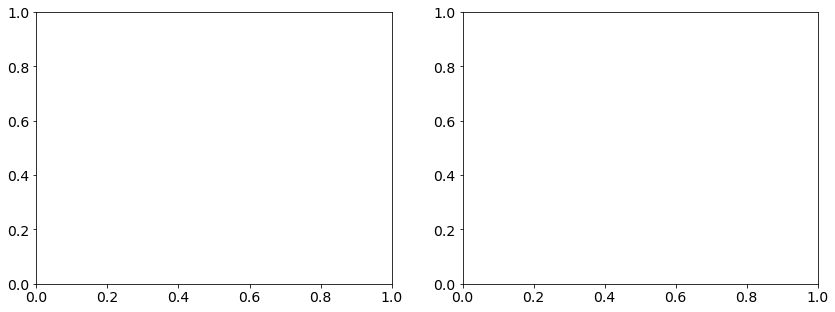

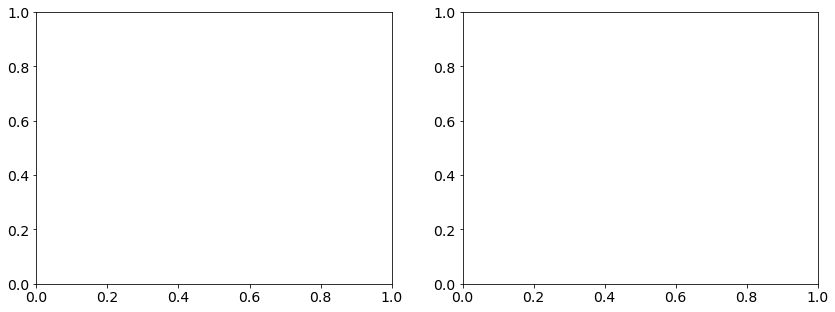

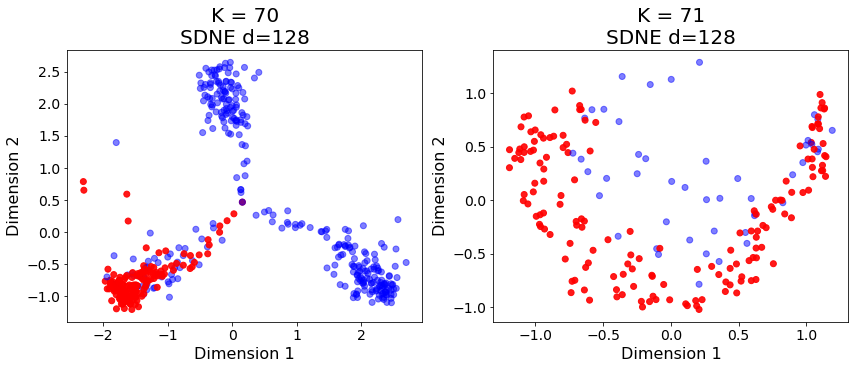

In [34]:
graphNames = ["facebook"]
#graphNames = ["physics", "lastfm", "BA-5", "BA-10", "ER-2", "ER-4"]
#graphNames = ["wiki", "facebook", "ppi", "physics", "lastfm", "AS", "ER-2", "ER-4", "BA-5", "BA-10"]
for graphName in graphNames:
    analyze_embedded_cores(graphName)

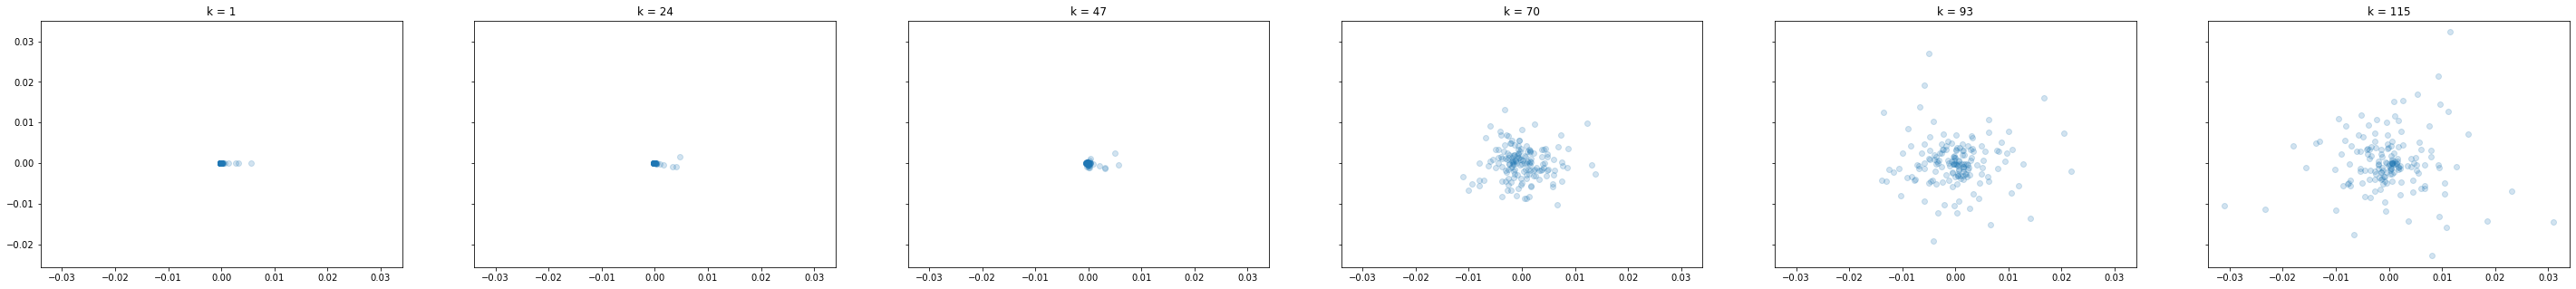

In [15]:
graphNames = ["facebook"]
fig, axs = plt.subplots(nrows=len(graphNames), ncols=6, figsize=(50, 5*len(graphNames)), sharex=True, sharey=True)
for r in range(len(graphNames)):
    graphName = graphNames[r]
    
    with open("embeddings/{}_embeddings.pickle".format(graphName), "rb") as pickleFile:
            embeddings = pickle.load(pickleFile)
    with open("cores/{}_cores.pickle".format(graphName), "rb") as pickleFile:
        cores = pickle.load(pickleFile)
        
    d_str = "10"
    alg_name = "lap"
    compare_degenerate_cores(embeddings[d_str][1],\
                            cores,\
                            alg_name,\
                            int(d_str),\
                            axs)

In [6]:
def max_core_completeness(graphName):
    with open("cores/{}_cores.pickle".format(graphName), "rb") as pickleFile:
            cores = pickle.load(pickleFile)
    maxCore = cores[-1]
    n = len(maxCore)
    complete_graph_edges = int((n**2 - n)/2)
    percentComplete = 100*len(list(maxCore.edges()))/complete_graph_edges
    print("The Max Core for {} is {} percent complete and {} nodes".format(graphName,
                                                                           str(percentComplete),
                                                                           str(n)))

def core_completeness(core):
    n = len(core)
    complete_graph_edges = int((n**2 - n)/2)
    percentComplete = 100*len(core.edges())/complete_graph_edges
    return percentComplete

In [18]:
graphNames = ["wiki", "facebook", "ppi", "physics", "lastfm", "AS", "BA-5", "BA-10", "ER-2", "ER-4"]
for graphName in graphNames:
    max_core_completeness(graphName)

The Max Core for wiki is 52.62915977201691 percent complete and 148 nodes
The Max Core for facebook is 89.84923002499396 percent complete and 158 nodes
The Max Core for ppi is 40.434930343187226 percent complete and 109 nodes
The Max Core for physics is 100.0 percent complete and 32 nodes
The Max Core for lastfm is 61.424606845513416 percent complete and 47 nodes
The Max Core for AS is 54.52716297786721 percent complete and 71 nodes
The Max Core for BA-5 is 0.1998399679935987 percent complete and 5000 nodes
The Max Core for BA-10 is 0.39927985597119425 percent complete and 5000 nodes
The Max Core for ER-2 is 0.2824717925597096 percent complete and 3328 nodes
The Max Core for ER-4 is 0.445538336553545 percent complete and 4326 nodes


In [6]:
def jaccard_index(a_list, b_list):
    #a_list and b_list must each be lists of unique elements
    intersection = set(a_list).intersection(set(b_list))
    return len(intersection) / (len(a_list) + len(b_list) - len(intersection))

a_list = [1, 2, 4]
b_list = [1, 2, 3]
jaccard_index(a_list, b_list)

0.5

In [18]:
def neighbor_jaccard_by_core(graphName):
    with open("cores/{}_cores.pickle".format(graphName), "rb") as pickleFile:
            cores = utils.get_cores_subset(pickle.load(pickleFile))
    
    plt.figure()
    ax = plt.subplot()
    ax.set_title("{}: Average Jaccard Score During Peeling".format(graphName))
    
    _, maxCore = cores[-1]
    avg_jaccard_by_core = []
    for subset_idx in range(len(cores)):
        core_idx, core = cores[subset_idx]
        jaccard_scores = []
        for i in range(len(maxCore)):
            for j in range(i+1, len(maxCore)):
                jaccard_scores.append(jaccard_index(
                    list(core.neighbors(list(maxCore.nodes())[i])),
                    list(core.neighbors(list(maxCore.nodes())[j]))))
        #ax.hist(jaccard_scores, histtype="step", bins=100, label=str(core_idx))
        sns.kdeplot(jaccard_scores, label=str(core_idx))
        avg_jaccard = np.mean(np.array(jaccard_scores))
        avg_jaccard_by_core.append(avg_jaccard)
    
    ax.legend()
    #ax.plot(list(range(1, len(cores) + 1)), avg_jaccard_by_core)
    

wiki
facebook
ppi
physics


/home/liu.davi/.conda/envs/graphxai/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/liu.davi/.conda/envs/graphxai/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/liu.davi/.conda/envs/graphxai/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/liu.davi/.conda/envs/graphxai/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


lastfm
AS


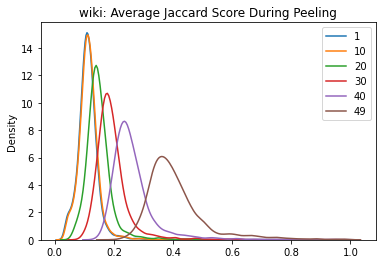

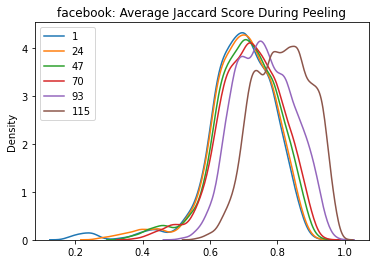

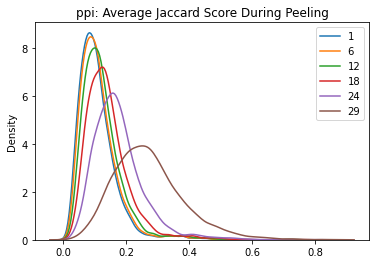

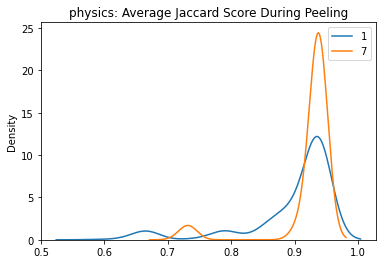

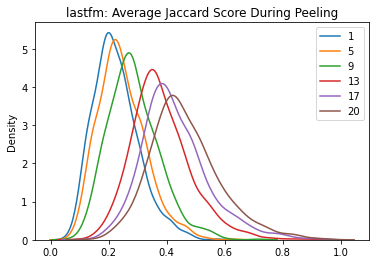

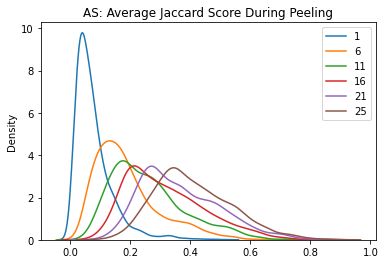

In [19]:
graphNames = ["wiki", "facebook", "ppi", "physics", "lastfm", "AS"]
for graphName in graphNames:
    print(graphName)
    neighbor_jaccard_by_core(graphName)

## Color Cores in Original Embedding

In [11]:
 def embed_entire_graph_color_coreness(embeddings_by_alg, cores, alg_name, d_int,
                                       ax_entire_graph,
                                       axs_by_core):
    firstCore = cores[0]

    x,y = get_xy(embeddings_by_alg[alg_name][0][1], d_int)
    c = []
    c_str = []
    labels = []
    #assert(len(colors) == len(embeddings_by_alg[alg_name]))
    for i in range(len(firstCore)):
        current_node = list(firstCore.nodes())[i]
        for j in range(len(embeddings_by_alg[alg_name]) - 1, -1, -1): #search cores inside-out
        #hardcoded_indices = [0, 58, 59, 60, 61, 114]
        #for j in range(5, -1, -1):
            #core_idx = embeddings_by_alg[alg_name][hardcoded_indices[j]][0] - 1
            core_idx = embeddings_by_alg[alg_name][j][0] - 1
            if current_node in cores[core_idx]:
                c.append(get_color(colors[j], alphas[j]))
                c_str.append(colors[j])
                labels.append(core_idx + 1)
                break
    ax_entire_graph.scatter(x, y, c=c, label=labels)
    #handles, labels = scatter.legend_elements(prop="label", alpha=0.6)
    #ax.legend(handles, labels, loc="upper right", title="Sizes")
    
    assert(len(axs_by_core) == len(colors) - 1)
    for i in range(len(colors) - 1):
        subplot_colors = []
        for color in c_str:
            if color == colors[-1]:
                subplot_colors.append(color)
            elif color in colors[i:]:
                subplot_colors.append(get_color(colors[i], alphas[i]))
            else:
                subplot_colors.append(get_color("grey", 0.1))
        axs_by_core[i].scatter(x, y, c=subplot_colors)

In [10]:
graphNames = ["wiki", "facebook", "ppi", "physics", "lastfm"]
for r in range(len(graphNames)):
    graphName = graphNames[r]
    
    with open("embeddings/{}_embeddings.pickle".format(graphName), "rb") as pickleFile:
            embeddings = pickle.load(pickleFile)
    with open("cores/{}_cores.pickle".format(graphName), "rb") as pickleFile:
        cores = pickle.load(pickleFile)
        
    d_str = "10"
    alg_name = "n2v"
    fig, ax_entire_graph = plt.subplots(figsize=(10, 10))
    ax_entire_graph.set_title(graphName)
    
    fig, axs_by_core = plt.subplots(nrows=1, ncols = len(colors) - 1, figsize=(10 * (len(colors) - 1), 10))
    embed_entire_graph_color_coreness(embeddings[d_str][1],\
                            cores,\
                            alg_name,\
                            int(d_str),\
                            ax_entire_graph,\
                            axs_by_core)

KeyboardInterrupt: 

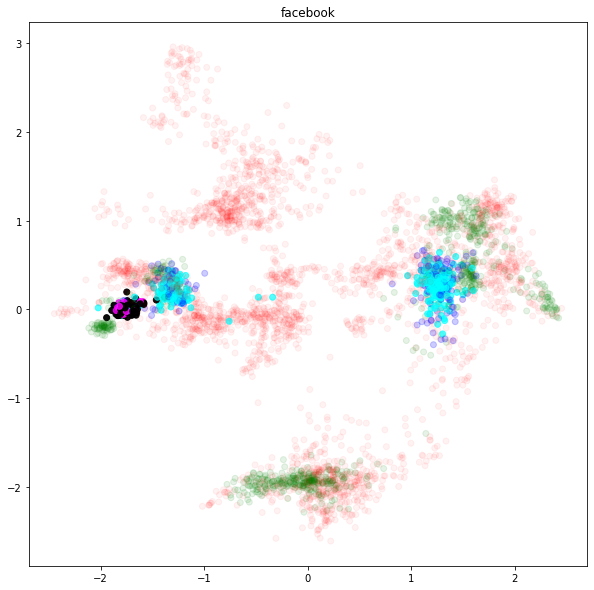

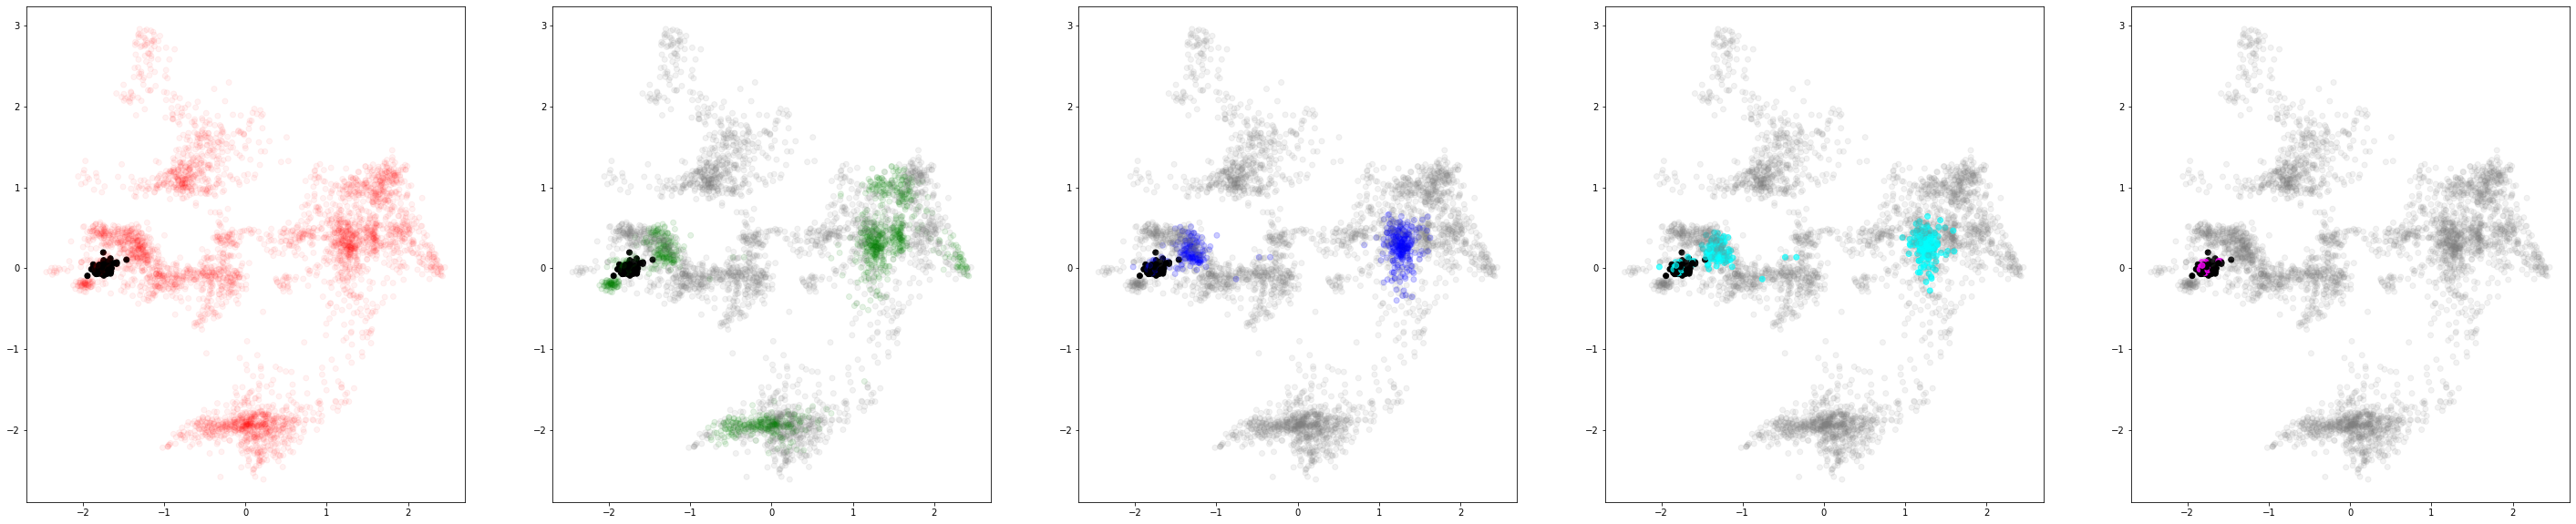

In [16]:
graphNames = ["facebook"]
for r in range(len(graphNames)):
    graphName = graphNames[r]
    
    with open("embeddings/{}_embeddings.pickle".format(graphName), "rb") as pickleFile:
            embeddings = pickle.load(pickleFile)
    with open("cores/{}_cores.pickle".format(graphName), "rb") as pickleFile:
        cores = pickle.load(pickleFile)
        
    d_str = "10"
    alg_name = "n2v"
    fig, ax_entire_graph = plt.subplots(figsize=(10, 10))
    ax_entire_graph.set_title(graphName)
    
    fig, axs_by_core = plt.subplots(nrows=1, ncols = len(colors) - 1, figsize=(10 * (len(colors) - 1), 10))
    embed_entire_graph_color_coreness(embeddings[d_str][1],\
                            cores,\
                            alg_name,\
                            int(d_str),\
                            ax_entire_graph,\
                            axs_by_core)

Core 61 is 22.055003819709704 percent complete
Core 62 is 22.587704666462056 percent complete
Core 63 is 22.753493662658432 percent complete
Core 64 is 23.088296833589062 percent complete
Core 65 is 23.38317007504153 percent complete
Core 66 is 23.856821729162153 percent complete
Core 67 is 24.661322645290582 percent complete
Core 68 is 25.266813699394124 percent complete
Core 69 is 25.595859429366737 percent complete
Core 70 is 26.074490768044278 percent complete
Core 71 is 75.77235772357723 percent complete
Core 72 is 75.77235772357723 percent complete
Core 73 is 76.17115811841978 percent complete
Core 74 is 76.56928254401795 percent complete
Core 75 is 76.56928254401795 percent complete
Core 76 is 76.9617260233486 percent complete
Core 77 is 76.9617260233486 percent complete
Core 78 is 76.9617260233486 percent complete
Core 79 is 76.9617260233486 percent complete
Core 80 is 76.9617260233486 percent complete


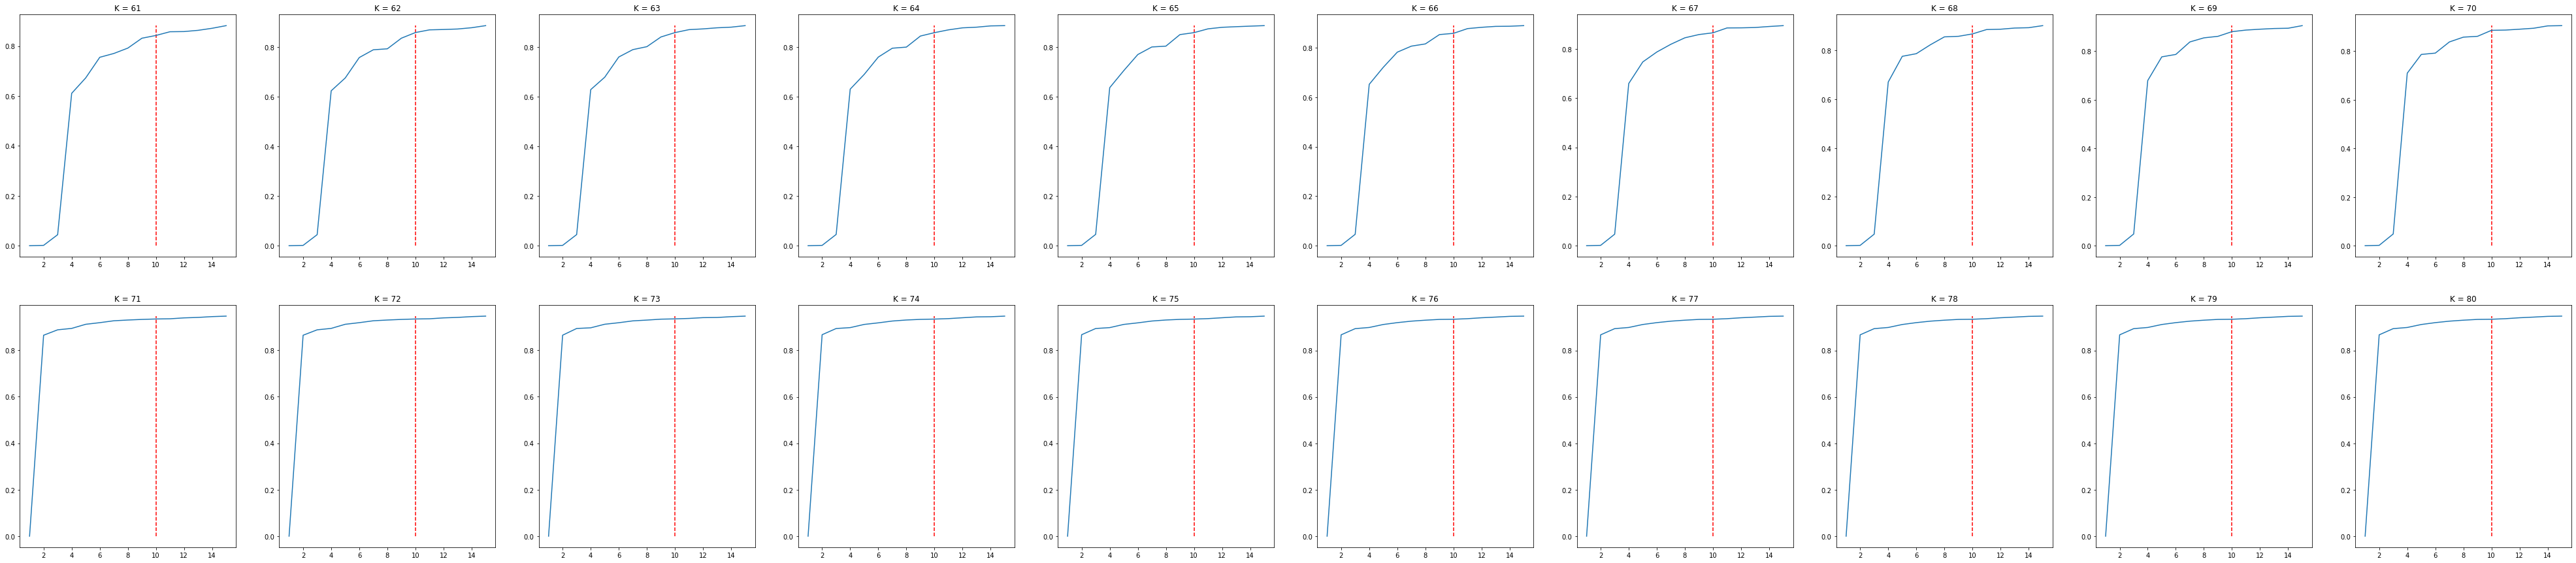

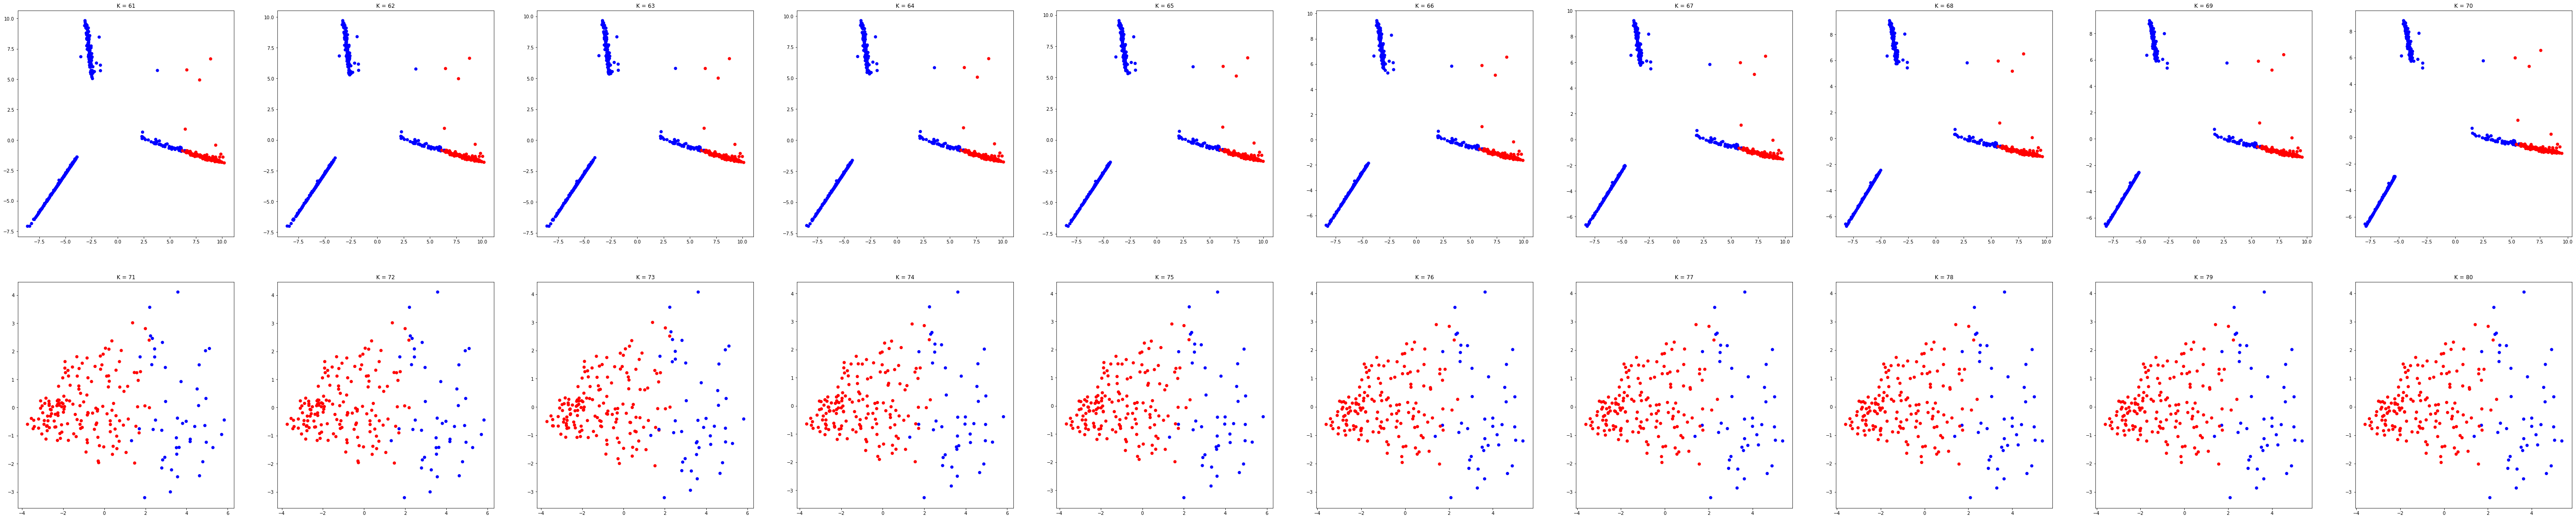

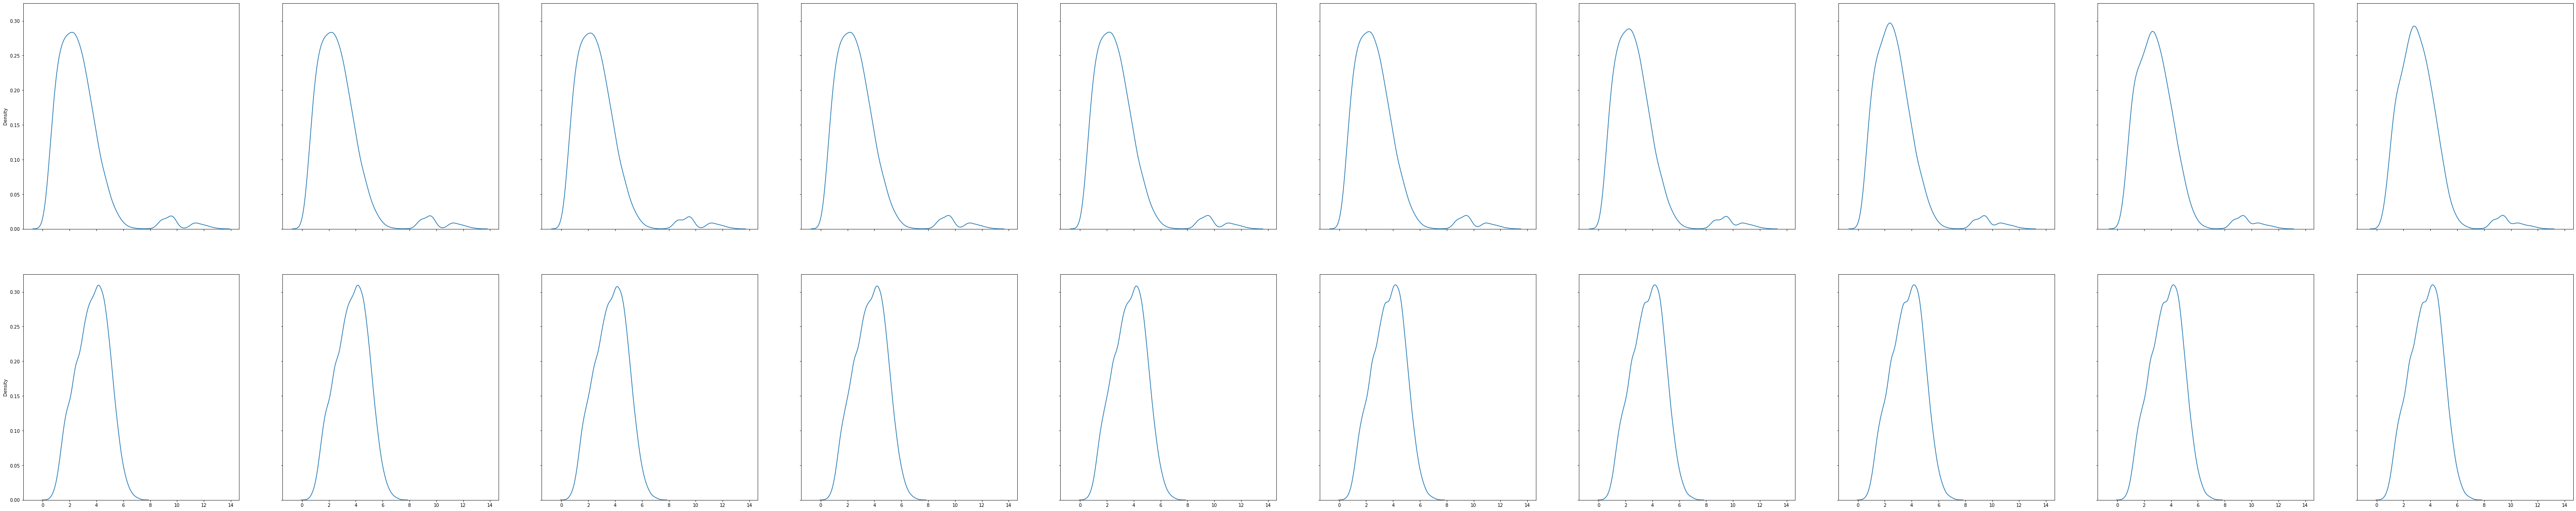

In [25]:
graphName = "facebook"
with open("cores/{}_cores.pickle".format(graphName), "rb") as pickleFile:
        cores = pickle.load(pickleFile)

start_core_idx = 60
end_core_idx = 80
ncols = 10
d = 10
random_state=42
fig, axs = plt.subplots(nrows=2, ncols=ncols, figsize=(70,15))
fig_embeddings, axs_embeddings = plt.subplots(nrows=2, ncols=ncols, figsize=(100,20))
fig_distances, axs_distances = plt.subplots(nrows=2, ncols=ncols, figsize=(100,20), sharex=True, sharey=True)

for core_idx in range(start_core_idx, end_core_idx):
    core = cores[core_idx]
    
    ######Percent Complete
    print("Core {} is {} percent complete".format(core_idx + 1, core_completeness(core)))
    
    ######Eigenvalues 
    L_sym = nx.linalg.laplacianmatrix.normalized_laplacian_matrix(core)
    
    num_eigenvalues = int(1.5*d)
    w, v = lg.eigs(L_sym, k=num_eigenvalues, which='SM')
    idx = np.argsort(w) # sort eigenvalues
    w = w[idx].real
    
    r = int((core_idx - start_core_idx)/ncols)
    c = (core_idx - start_core_idx)%ncols
    axs[r][c].plot(list(range(1, len(w)+1)), w)
    axs[r][c].vlines(x=d, ymin=0, ymax=max(w), colors="r", linestyles="dashed")
    axs[r][c].set_title("K = {}".format(str(core_idx + 1)))
    
    #######Embeddings 
#     embedding = SpectralEmbedding(n_components=d,
#                                  affinity="precomputed",
#                                  n_jobs=-1,
#                                  random_state=random_state)\
#                 .fit_transform(nx.linalg.graphmatrix.adjacency_matrix(core))
    embedding = TruncatedSVD(n_components=d,
                   random_state=random_state).\
                fit_transform(nx.linalg.graphmatrix.adjacency_matrix(core))
    x,y = get_xy(embedding, d)
    colors = ["red" if list(core.nodes())[i] in cores[-1]
                 else "blue" 
         for i in range(len(core))]
    axs_embeddings[r][c].scatter(x,y,c=colors)
    axs_embeddings[r][c].set_title("K = {}".format(str(core_idx + 1)))
    
    ########Distances
    distances = get_distances([embedding[i] for i in range(len(core)) if list(core.nodes())[i] in cores[-1]])
    sns.kdeplot(distances, ax=axs_distances[r][c])

/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/seaborn/distributions.py:352: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)
/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/seaborn/distributions.py:352: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)
/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/seaborn/distributions.py:352: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)
/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/seaborn/distributions.py:352: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)
/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/seaborn/distributions.py:352: UserWarning: Att

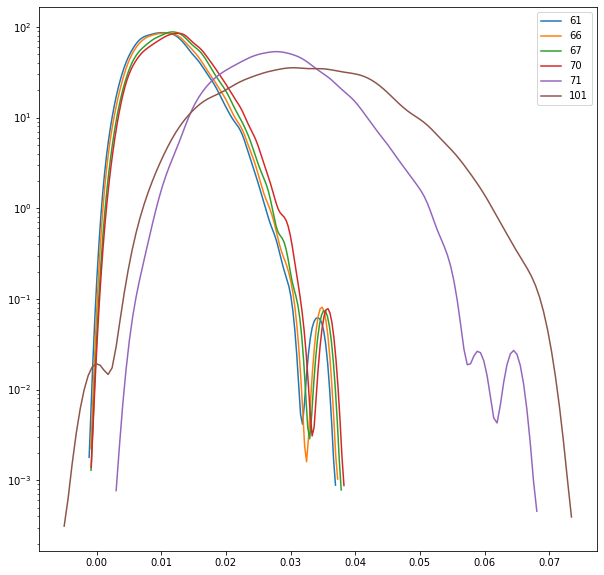

In [10]:
graphName = "facebook"
with open("cores/{}_cores.pickle".format(graphName), "rb") as pickleFile:
        cores = pickle.load(pickleFile)

d = 20
random_state=42
plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.set_yscale("log")
for core_idx in [60, 65, 66, 69, 70, 100]:
    core = cores[core_idx]
    
    #######Embeddings 
    embedding = SpectralEmbedding(n_components=d,
                                 affinity="precomputed",
                                 n_jobs=-1,
                                 random_state=random_state)\
                .fit_transform(nx.linalg.graphmatrix.adjacency_matrix(core))
    
    ########Distances
    distances = get_distances([embedding[i] for i in range(len(core)) if list(core.nodes())[i] in cores[-1]])
    sns.kdeplot(distances, ax=ax, label=str(core_idx + 1))
ax.legend()

KeyboardInterrupt: 

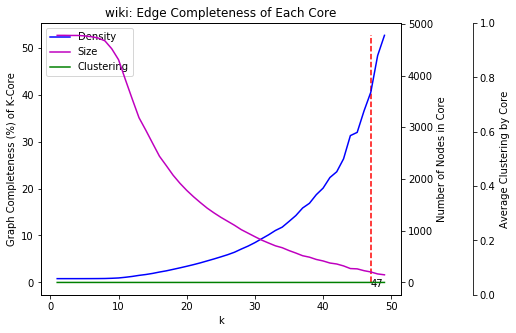

In [19]:
#graphNames = ["karate"]
graphNames = ["wiki", "facebook", "ppi", "physics", "lastfm", "AS", "ER-2", "ER-4", "BA-5", "BA-10", "BTER-from-BA", "BTER-arbitrary"]
for r in range(len(graphNames)):
    graphName = graphNames[r]
    
    with open("cores/{}_cores.pickle".format(graphName), "rb") as pickleFile:
        cores = pickle.load(pickleFile)
    
    completeness_by_core = [core_completeness(core) for core in cores]
    size_by_core = [len(core) for core in cores]
    clustering_by_core = [cluster.average_clustering(core) for core in cores]
    
    increase_by_k = np.array(completeness_by_core[1:]) - np.array(completeness_by_core[:-1])
    threshold = np.argmax(increase_by_k) + 1 #threshold is k before the biggest increase
    fig, ax_density = plt.subplots(figsize=(8,5))
    fig.subplots_adjust(right=0.75)
    ax_size = ax_density.twinx()
    ax_clustering = ax_density.twinx()
    ax_clustering.spines["right"].set_position(("axes", 1.2))

    density_handle, = ax_density.plot(list(range(1, len(cores) + 1)), completeness_by_core, "b", label="Density")
    ax_density.vlines(x=threshold,ymin=0, ymax=max(completeness_by_core), color="red", linestyles="dashed")
    if r < 6: 
        ax_density.text(threshold, -1, str(threshold))
    else:
        ax_density.text(threshold, -0.01, str(threshold))
    
    ax_density.set_title("{}: Edge Completeness of Each Core".format(graphName))
    ax_density.set_xlabel("k")
    ax_density.set_ylabel("Graph Completeness (%) of K-Core")
    
    size_handle, = ax_size.plot(list(range(1, len(cores) + 1)), size_by_core, "m", label="Size")
    ax_size.set_ylabel("Number of Nodes in Core")
    
    clustering_handle, = ax_size.plot(list(range(1, len(cores) + 1)), clustering_by_core, "g", label="Clustering")
    ax_clustering.set_ylabel("Average Clustering by Core")
    
    ax_density.legend(handles=[density_handle, size_handle, clustering_handle])

## Graph Network Statistics

In [8]:
graph_metadata = [
    {"name": "karate", "edgelist_path": "../node2vec/graph/karate.edgelist"},
    {"name": "ppi", "edgelist_path": "../node2vec/graph/ppi.edgelist"},
    {"name": "wiki", "edgelist_path": "../node2vec/graph/wikipedia.edgelist"},
    {"name": "facebook", "edgelist_path": "../node2vec/graph/facebook_combined.edgelist"},
    {"name": "physics", "edgelist_path": "../node2vec/graph/ca-HepTh.edgelist"},
    {"name": "lastfm", "edgelist_path": "../node2vec/graph/lastfm_asia_edges.edgelist"},
    {"name": "AS", "edgelist_path": "../node2vec/graph/AS.edgelist"},
    {"name": "BA-5", "edgelist_path": "../node2vec/graph/BA_5000_5.edgelist"},
    {"name": "BA-10", "edgelist_path": "../node2vec/graph/BA_5000_10.edgelist"},
    {"name": "ER-2", "edgelist_path": "../node2vec/graph/ER_5000_2.edgelist"},
    {"name": "ER-4", "edgelist_path": "../node2vec/graph/ER_5000_4.edgelist"},
    {"name": "BTER-arbitrary", "edgelist_path": "../node2vec/graph/BTER_5000_arbitrary.edgelist"},
    {"name": "BTER-from-BA", "edgelist_path": "../node2vec/graph/BTER_from_BA_5000_5.edgelist"},
    {"name": "enron", "edgelist_path": "../node2vec/graph/Email-Enron.edgelist"}
]


structure_statistics = {
    "name": [],
    "num_nodes": [],
    "num_edges": [],
    "num_components": [],
    "min_degree": [],
    "avg_degree": [],
    "max_degree": [],
    "clustering_coef": []
}

core_statistics = {
    "name": [],
    "degeneracy": [],
    "degen_core_size": [],
    "percent_in_degen": [],
    "degen_num_components": [],
    "num_shells": []
}
for graph_metadatum in graph_metadata:
    graphName = graph_metadatum["name"]
    nx_graph = nx.read_edgelist(graph_metadatum["edgelist_path"])
    with open("cores/{}_cores.pickle".format(graphName), "rb") as pickleFile:
            cores = pickle.load(pickleFile)
    
    ######## Structure Statistics #################
    structure_statistics["name"].append(graphName)    
    # Number of nodes
    structure_statistics["num_nodes"].append(len(nx_graph))
    
    # Number of edges 
    structure_statistics["num_edges"].append(len(nx_graph.edges()))
    
    # Number of components
    structure_statistics["num_components"].append(nx.algorithms.components.number_connected_components(nx_graph))
    
    degrees = np.array([node_degree[1] for node_degree in list(nx_graph.degree)])
    # Min. Degree 
    structure_statistics["min_degree"].append(min(degrees))
    
    # Avg. Degree
    structure_statistics["avg_degree"].append(np.sum(degrees)/len(degrees))
    
    # Max Degree
    structure_statistics["max_degree"].append(max(degrees))
    
    # Avg. Clustering Coefficient
    structure_statistics["clustering_coef"].append(nx.algorithms.cluster.average_clustering(nx_graph))
    
    ######## Core Statistics #################
    core_statistics["name"].append(graphName)
    # Number of Cores
    core_statistics["degeneracy"].append(len(cores)) 
    
    # Number of Nodes in Degenerate Core
    core_statistics["degen_core_size"].append(len(cores[-1]))
    
    # Percentage nodes in Degenerate Core
    core_statistics["percent_in_degen"].append(100*len(cores[-1])/len(nx_graph))
    
    # Number of Components in Degenerate Core
    core_statistics["degen_num_components"].append(nx.algorithms.components.number_connected_components(cores[-1]))
    
    # Number of shells
    core_statistics["num_shells"].append(len(np.unique([len(core) for core in cores])))
    
structure_statistics_pd = pd.DataFrame(structure_statistics)
core_statistics_pd = pd.DataFrame(core_statistics)

In [24]:
structure_statistics_pd

,name,num_nodes,num_edges,num_components,min_degree,avg_degree,max_degree,clustering_coef
0,karate,34,77,1,1,4.529412,17,0.565075
1,ppi,3890,38739,35,1,19.917224,595,0.146449
2,wiki,4777,92517,1,2,38.734352,3646,0.538570
3,facebook,4039,88234,1,1,43.691013,1045,0.605547
4,physics,9877,25998,429,1,5.264352,65,0.471439
5,lastfm,7624,27806,1,1,7.294334,216,0.219418
6,AS,22963,48436,1,1,4.218613,2390,0.230448
7,BA-5,5000,24975,1,5,9.990000,389,0.012631
8,BA-10,5000,49900,1,10,19.960000,446,0.019813
9,ER-2,5000,24865,1,1,9.946000,22,0.001911


In [9]:
core_statistics_pd

,name,degeneracy,degen_core_size,percent_in_degen,degen_num_components,num_shells
0,karate,4,6,17.647059,1,4
1,ppi,29,109,2.802057,1,29
2,wiki,49,148,3.098179,1,47
3,facebook,115,158,3.911859,1,96
4,physics,31,32,0.323985,1,13
5,lastfm,20,47,0.616474,1,20
6,AS,25,71,0.309193,1,25
7,BA-5,5,5000,100.000000,1,1
8,BA-10,10,5000,100.000000,1,1
9,ER-2,7,3328,66.560000,1,7


In [5]:
graphNames = ["wiki", "facebook", "ppi", "lastfm", "physics", "AS", "ER-2", "ER-4", "BA-5", "BA-10", "enron", "BTER-from-BA", "BTER-arbitrary"]
one_core_dict = {"name": [], "n": [], "m": [], "density": []}
for graphName in graphNames:
    with open("cores/{}_cores.pickle".format(graphName), "rb") as pickleFile:
            cores = pickle.load(pickleFile)
    one_core_dict["name"].append(graphName)
    n = len(cores[-1])
    m = len(cores[-1].edges)
    one_core_dict["n"].append(n)
    one_core_dict["m"].append(m)
    one_core_dict["density"].append(2 * m / (n * (n-1)))
#     k_s = list(range(1, len(cores) + 1))
#     num_components = [nx.algorithms.components.number_connected_components(core) for core in cores]
#     fig, ax = plt.subplots()
#     ax.plot(k_s, num_components)
#     ax.set_title(graphName)
pd.DataFrame(one_core_dict)

,name,n,m,density
0,wiki,148,5725,0.526292
1,facebook,158,11144,0.898492
2,ppi,109,2380,0.404349
3,lastfm,47,664,0.614246
4,physics,32,496,1.000000
5,AS,71,1355,0.545272
6,ER-2,3328,15638,0.002825
7,ER-4,4326,41680,0.004455
8,BA-5,5000,24975,0.001998
9,BA-10,5000,49900,0.003993


In [14]:
original_ppi = nx.read_edgelist("../node2vec/graph/ppi.edgelist")
print(len(original_ppi))
print(len(original_ppi.edges))
original_ppi.remove_edges_from(nx.selfloop_edges(original_ppi))
print(len(original_ppi))
print(len(original_ppi.edges))
degrees = list(original_ppi.degree)
for node, degree in degrees:
    if degree == 0:
        print(node)

3890
38739
3890
37845
33
55
117
246
357
362
363
508
639
786
1040
1171
1277
1591
1803
1856
1888
1900
2031
2039
2081
2250
2295
2496
2536
2778
2850
3404
3558
3769


In [13]:
degrees

[('0', 18),
 ('3361', 376),
 ('137', 152),
 ('2158', 33),
 ('974', 43),
 ('1839', 19),
 ('1552', 32),
 ('1586', 16),
 ('243', 25),
 ('3583', 47),
 ('206', 28),
 ('3405', 28),
 ('3225', 85),
 ('2137', 4),
 ('954', 98),
 ('1903', 60),
 ('3644', 17),
 ('3006', 31),
 ('2367', 5),
 ('1', 13),
 ('992', 56),
 ('3318', 94),
 ('2083', 23),
 ('2788', 108),
 ('805', 41),
 ('3574', 309),
 ('3788', 219),
 ('2799', 191),
 ('2802', 205),
 ('1462', 165),
 ('823', 276),
 ('824', 418),
 ('1309', 187),
 ('2', 2),
 ('3473', 3),
 ('428', 51),
 ('3', 3),
 ('529', 9),
 ('898', 24),
 ('3757', 55),
 ('4', 31),
 ('1669', 26),
 ('1799', 8),
 ('10', 46),
 ('1042', 382),
 ('532', 152),
 ('2329', 36),
 ('3738', 7),
 ('3589', 17),
 ('1824', 57),
 ('2928', 3),
 ('2985', 49),
 ('2162', 61),
 ('2848', 9),
 ('1612', 47),
 ('1613', 105),
 ('1614', 153),
 ('1750', 28),
 ('3680', 53),
 ('2658', 165),
 ('488', 48),
 ('2154', 34),
 ('2796', 4),
 ('2670', 98),
 ('880', 18),
 ('881', 20),
 ('882', 3),
 ('1654', 31),
 ('1556', 

In [17]:
nx_graph = nx.read_edgelist("../node2vec/graph/facebook_combined.edgelist")
degrees = np.array([node_degree[1] for node_degree in list(nx_graph.degree)])

In [18]:
degrees

array([347,  17,  10, ...,   2,   4,   9])

In [16]:
import json
with open("config/all_graph.json", "r") as configFile:
    config = json.load(configFile)

In [17]:
config

{'graphNames': ['wiki',
  'facebook',
  'ppi',
  'lastfm',
  'physics',
  'AS',
  'BA-5',
  'BA-10',
  'ER-2',
  'ER-4',
  'enron',
  'BTER-arbitrary',
  'BTER-from-BA'],
 'd_s': [2, 10, 20],
 'random_state': 42,
 'override': False}

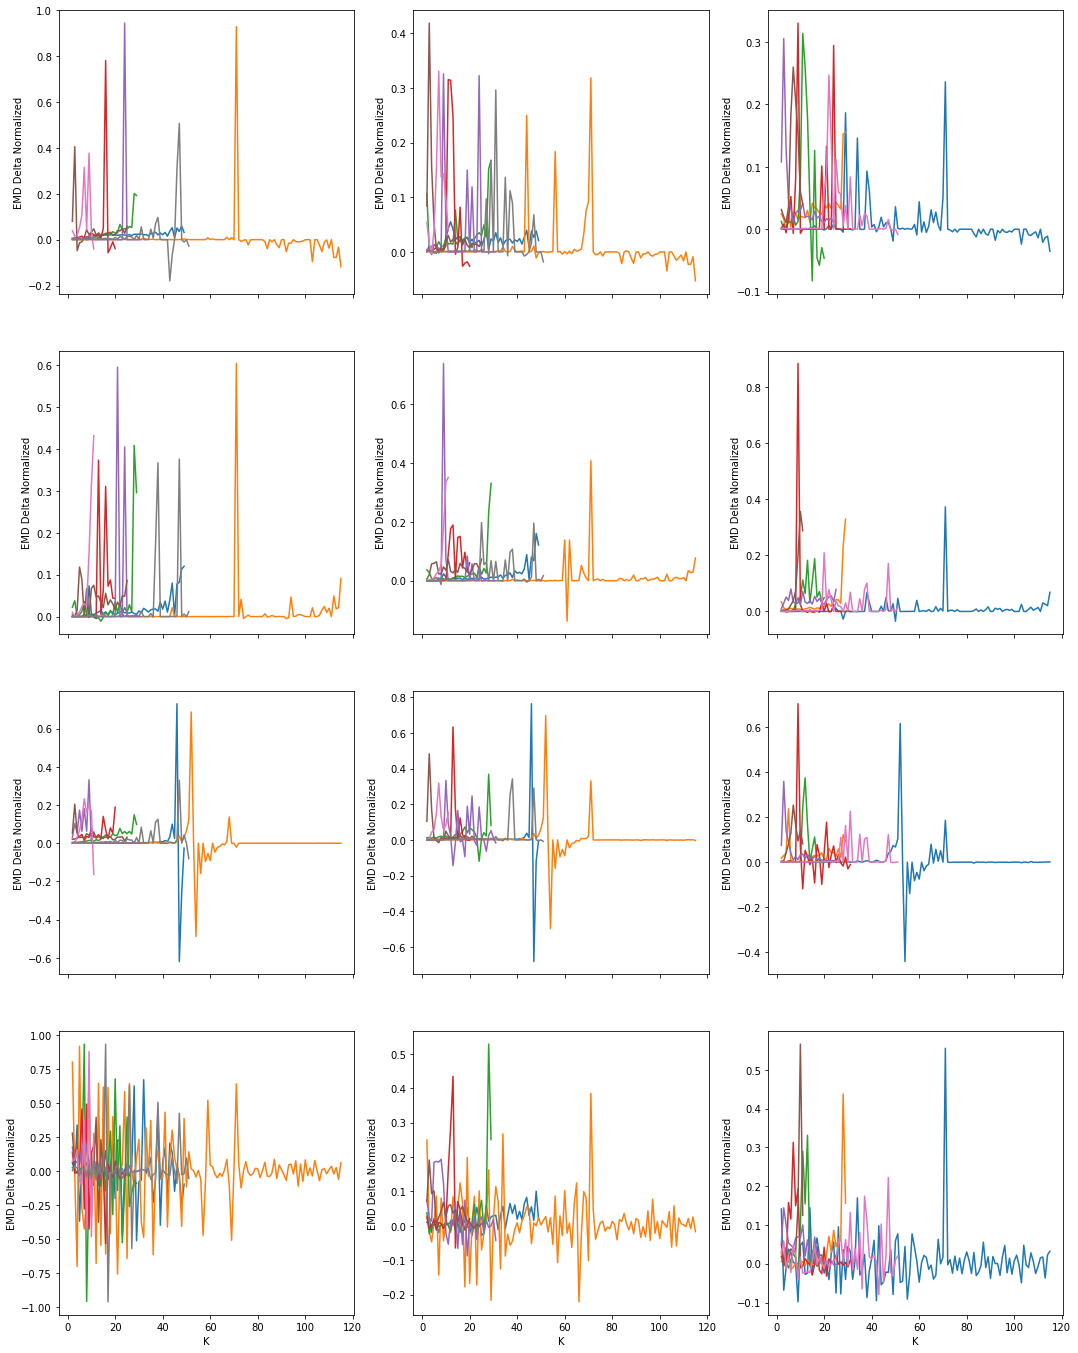

In [10]:
with open("pickles/emd_deltas_pd.pickle", "rb") as pickleFile:
    description, emd_deltas_pd = pickle.load(pickleFile)
    #print(description)
    #print(emd_deltas_pd)
algs = ["pca", "lap", "HOPE", "n2v"]
d_s = ["2", "10", "20"]

fig, axs = plt.subplots(nrows=len(algs), ncols=len(d_s),figsize=(6*len(d_s), 6*len(algs)), sharex=True)
for r in range(len(algs)):
    for c in range(len(d_s)):
        alg = algs[r]
        d = d_s[c]
        
        emd_deltas_pd_subset = emd_deltas_pd[np.all([emd_deltas_pd["Dimension"] == d,\
                                              emd_deltas_pd["Algorithm Name"] ==alg], axis=0)]
        #print(emd_deltas_pd_subset)
        sns.lineplot(x="K", y="EMD Delta Normalized", hue="Graph Name", legend=False, ax=axs[r][c], data=emd_deltas_pd_subset)